# Calculate barotropic and meridional streamfunction

In this notebook, the barotropic streamfunction, the vertical velocity and the meridional streamfunction is calculated. The crucial diagnostic output for each of these veraibles is the veriable mass_flux which is the horizontal transport (velocity times cell height and edge length) at all edges.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import sys
import pyicon as pyic
import cartopy

In [3]:
ccrs_proj = cartopy.crs.PlateCarree()

## Specify data set

In [4]:
run = 'nib0004'
runname = 'icon_08'
gname = 'r2b6'
lev = 'L64'

path_data     = f'/mnt/lustre01/work/mh0033/m300602/proj_vmix/icon/{runname}/icon-oes/experiments/{run}/'
path_grid     = f'/mnt/lustre01/work/mh0033/m300602/icon/grids/{gname}/'
path_ckdtree  = f'{path_grid}ckdtree/'
fpath_ckdtree = f'{path_grid}ckdtree/rectgrids/{gname}_res0.30_180W-180E_90S-90N.npz'
fpath_fx      = f'{path_grid}{gname}_{lev}_fx.nc'

In [5]:
IcD = pyic.IconData(
               fname        = run+'_????????????????.nc',
               path_data    = path_data,
               path_grid    = path_grid,
               gname        = gname,
               lev          = lev,
               do_triangulation = True,
               omit_last_file   = False
              )

## Load data

In [6]:
# --- specify time step
it = np.argmin(np.abs(IcD.times-np.datetime64('2295-01-01T00:00:00')))
# --- specify depth level
iz = np.argmin(np.abs(IcD.depthc-1000.))

# --- load data
f = Dataset(IcD.flist_ts[it], 'r')
mass_flux = f.variables['mass_flux'][IcD.its[it],:,:]
mass_flux_vint = mass_flux.sum(axis=0)
f.close()

## Barotopic streamfunction

pyicon comes with the function calc_bstr_vgrid which calculates the barotropic streamfunction on the vertices of the grid (vertically integrated transport between two arbitrary vertices). Usually, it is best to choose the North Pole as start point of the integration. In this case, the streamfunction is close to zero over all Europe, Africa, North- and South-America but it is not zero over Antarcica or Australia (or on some islands e.g. Madagascar).

In [7]:
# --- calculate barotropic streamfunction
bstr = pyic.calc_bstr_vgrid(IcD, mass_flux_vint, lon_start=0., lat_start=90.)

start finding indices
start calculating stream


Since we cannot plot variables on vertices directly (at the moment), we can either interpolate to cell centers or we interpolate to a regular grid.

In [8]:
# ----- interpolate from vertex grid to regular grid
lon, lat, bstri = pyic.interp_to_rectgrid(bstr, fpath_ckdtree, coordinates='vlat vlon')

We make two plot, one global plot of the streamfunction and one zoom to the North Atlantic supbolar gyre. Note that the streamfunction is not necessarily zero over land but it should be close to zero over all the major continents (except Antarctica).

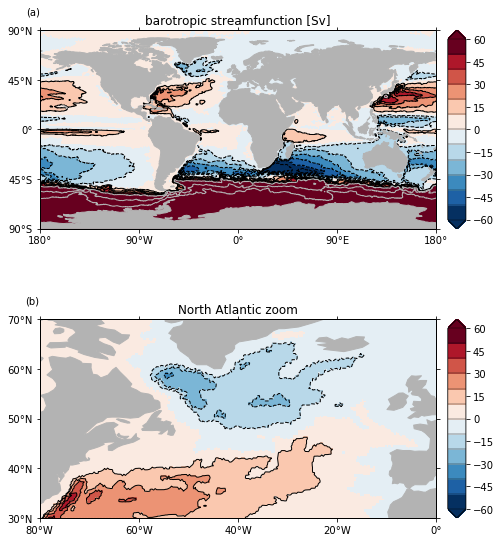

In [9]:
# --- barotropic streamfunction
hca, hcb = pyic.arrange_axes(1,2, plot_cb=True, sasp=0.5, fig_size_fac=2.,
                               sharex=False, sharey=True, xlabel="", ylabel="",
                               projection=ccrs_proj,
                            )
ii=-1

for kk in range(2):
  ii+=1; ax=hca[ii]; cax=hcb[ii]

  # normal contours
  clim = 60
  cincr = 10
  conts = np.arange(-clim, clim, cincr)
  conts = conts[conts!=0.]
  hm = pyic.shade(lon, lat, bstri, ax=ax, cax=cax, transform=ccrs_proj,
                    clim=clim, cincr=cincr, conts=conts)

  # extra contours southern ocean
  conts = np.arange(60,400,40)
  hm = pyic.shade(lon, lat, bstri, ax=ax, cax=cax, transform=ccrs_proj,
                    conts=conts, use_pcol=False, contcolor='0.7')

# title and limits
ax = hca[0]
ax.set_title('barotropic streamfunction [Sv]')
xlim = [-180,180]
ylim = [-90,90]
pyic.plot_settings(ax, xlim, ylim, projection=ccrs_proj)

ax = hca[1]
ax.set_title('North Atlantic zoom')
xlim = [-80,0]
ylim = [30,70]
pyic.plot_settings(ax, xlim, ylim, projection=ccrs_proj)

## Vertical velocity

pyicon comes with the function calc_wvel which calculates the vertical velocity from the variable mass_flux by appying the horizontal divergence of mass_flux and vertically integrating the divergence from bottom to top.

In [10]:
# --- calculate vertical velocity
wvel = pyic.calc_wvel(IcD, mass_flux)

In the following the vertical velocity is plotted at 1000m depth in a global plot and zooming to the North Atlantic.

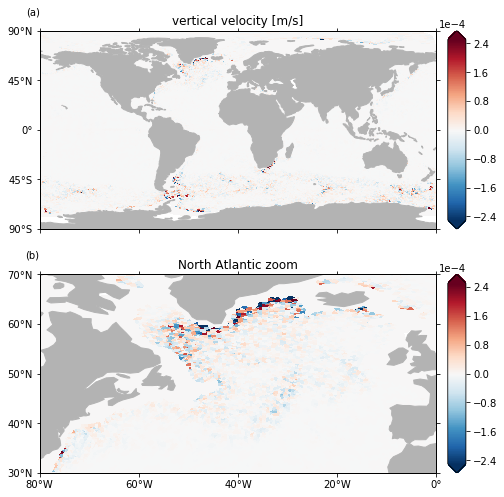

In [11]:
# --- vertical velocity
hca, hcb = pyic.arrange_axes(1,2, plot_cb=True, sasp=0.5, fig_size_fac=2.,
                               sharex=True, sharey=True, xlabel="", ylabel="",
                               projection=ccrs_proj,
                            )
ii=-1

for kk in range(2):
  ii+=1; ax=hca[ii]; cax=hcb[ii]
  hm = pyic.trishade(IcD.Tri, wvel[iz,:], ax=ax, cax=cax, clim=2.5e-4, transform=ccrs_proj)

ax = hca[0]
ax.set_title('vertical velocity [m/s]')
xlim = [-180,180]
ylim = [-90,90]
pyic.plot_settings(ax, xlim, ylim, projection=ccrs_proj)

# zoom to North Atlantic
ax = hca[1]
ax.set_title('North Atlantic zoom')
xlim = [-80,0]
ylim = [30,70]
pyic.plot_settings(ax, xlim, ylim, projection=ccrs_proj)

## Meridional overturning

Calculate meridional overturning from vertical velocity. The basin option tells over which ocean basin the integrations should be done, choose either "global", "atl", "indopac" or "indopacso".

In [12]:
# --- calculate meridional overturning
lat_mg = np.arange(-90.,90.,1.)
wTransp = wvel*IcD.cell_area[np.newaxis,:]

gmoc    = pyic.calc_moc(IcD.clat, wTransp,
                           basin='global',    fpath_fx=IcD.fpath_fx)
amoc    = pyic.calc_moc(IcD.clat, wTransp,
                           basin='atl',       fpath_fx=IcD.fpath_fx)
ipsomoc = pyic.calc_moc(IcD.clat, wTransp,
                           basin='indopacso', fpath_fx=IcD.fpath_fx)

In the following, we plot the overturning streamfunction for the North Atlantic, the Indo-Pacific and the global ocean.

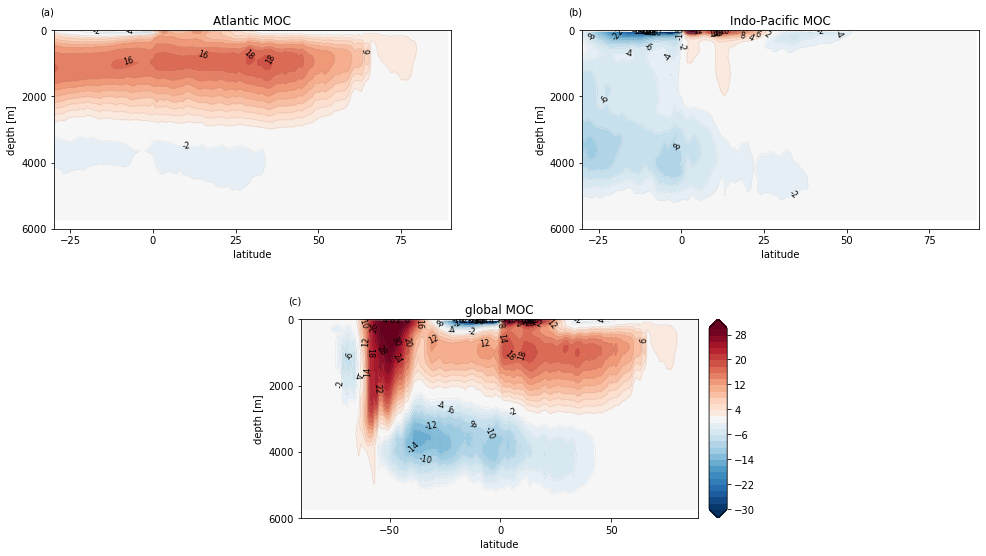

In [13]:
# ------ meridional overturning
hca, hcb = pyic.arrange_axes(2,2, plot_cb=[0,0,1,0], sasp=0.5, fig_size_fac=2,
                           sharex=False, sharey=False, xlabel="latitude", ylabel="depth [m]", )
ii=-1

# remove 4th axes and center 3rd axes
hca[3].remove()
ax=hca[2]
cax=hcb[2]
pos_ax = ax.get_position()
pos_cax = cax.get_position()
dx = -pos_ax.x0+0.5-0.5*pos_ax.width
ax.set_position([pos_ax.x0+dx, pos_ax.y0, pos_ax.width, pos_ax.height])
cax.set_position([pos_cax.x0+dx, pos_cax.y0, pos_cax.width, pos_cax.height])

# plot settings
clim = 30.
contfs = np.arange(-clim,clim+2.,2)
contfs = contfs[contfs!=0]
cont_props = dict(linewidths=0.1, colors='0.5')
clab_props = dict(fontsize=8, fmt='%.0f', colors='k')
cbticks = contfs[::4]

# ------ Atlantic MOC
ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lat_mg, IcD.depthi, amoc/1e6, ax=ax, cax=cax,
                  clim=clim, contfs=contfs, cbticks=cbticks)
hm = ax.contour(lat_mg, IcD.depthi, amoc/1e6, contfs, **cont_props)
ax.clabel(hm, **clab_props)
ax.set_xlim(-30,90)
ax.set_title('Atlantic MOC')

# ------ Indo-Pacific MOC
ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lat_mg, IcD.depthi, ipsomoc/1e6, ax=ax, cax=cax,
                 clim=clim, contfs=contfs, cbticks=cbticks)
hm = ax.contour(lat_mg, IcD.depthi, ipsomoc/1e6, contfs, **cont_props)
ax.clabel(hm, **clab_props)
ax.set_xlim(-30,90)
ax.set_title('Indo-Pacific MOC')

# ------ global MOC
ii+=1; ax=hca[ii]; cax=hcb[ii]
hm = pyic.shade(lat_mg, IcD.depthi, gmoc/1e6, ax=ax, cax=cax,
                 clim=clim, contfs=contfs, cbticks=cbticks)
hm = ax.contour(lat_mg, IcD.depthi, gmoc/1e6, contfs, **cont_props)
ax.clabel(hm, **clab_props)
ax.set_title('global MOC')

for ax in hca:
  ax.set_ylim(6000,0)